In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/londonbikes/sample.csv
/kaggle/input/londonbikes/test.csv
/kaggle/input/londonbikes/train.csv


Goal: Predict cnt
- 8 features originally 
- timestamp must be divided to hour of day, day of month, month of year, and year 
- This adds two features: hour of day and month of year
* 12223 examples in train, and 5191 examples in test.

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf

plt.style.use('ggplot')


In [191]:
import os
import glob
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/londonbikes/sample.csv
/kaggle/input/londonbikes/test.csv
/kaggle/input/londonbikes/train.csv


In [192]:
train_df = pd.concat([pd.read_csv(f) for f in glob.glob("../input/londonbikes/train.csv") ])
test_df = pd.concat([pd.read_csv(f) for f in glob.glob("../input/londonbikes/test.csv") ])
#data = pd.read_csv("train.csv")
train_df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
1,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
2,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
3,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0
4,2015-01-04 10:00:00,528,3.0,-0.5,93.0,12.0,3.0,0.0,1.0,3.0


Extracting hours, days, months, year

In [193]:
##We fix the train_df 
train_df['timestamp'] = train_df['timestamp'] .apply(lambda x :datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))
train_df['month'] = train_df['timestamp'].apply(lambda x : float(str(x).split(' ')[0].split('-')[1]))
train_df['day'] = train_df['timestamp'].apply(lambda x : float(str(x).split(' ')[0].split('-')[2]))
train_df['hour'] = train_df['timestamp'].apply(lambda x : float(str(x).split(' ')[1].split(':')[0]))

##We fix test_df 

test_df['timestamp'] = test_df['timestamp'] .apply(lambda x :datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))
test_df['month'] = test_df['timestamp'].apply(lambda x : float(str(x).split(' ')[0].split('-')[1]))
test_df['day'] = test_df['timestamp'].apply(lambda x : float(str(x).split(' ')[0].split('-')[2]))
test_df['hour'] = test_df['timestamp'].apply(lambda x : float(str(x).split(' ')[1].split(':')[0]))


We choose features to keep

In [194]:
test_timestamp = pd.Series(test_df['timestamp'])
#3 features
train_df.drop(columns=["timestamp", "t2", "wind_speed","weather_code", "is_holiday","is_weekend", "season", "month", "day"],axis =1, inplace=True)
test_df.drop(columns=[ "timestamp","t2", "wind_speed","weather_code", "is_holiday","is_weekend", "season", "month", "day"],axis=1, inplace=True)

#4 features
#train_df.drop(columns=["timestamp", "t2", "wind_speed", "is_holiday","is_weekend","season", "month", "day"],axis =1, inplace=True)
#test_df.drop(columns=[ "timestamp","t2", "wind_speed", "is_holiday","is_weekend", "season", "month", "day"],axis=1, inplace=True)


test_timestamp.head()

0   2015-01-04 00:00:00
1   2015-01-04 01:00:00
2   2015-01-04 03:00:00
3   2015-01-04 04:00:00
4   2015-01-04 05:00:00
Name: timestamp, dtype: datetime64[ns]

Starting with the model

In [195]:
train_df_mean = train_df.mean()
mean_cnt = train_df.mean()[0]
train_df_std = train_df.std()
std_cnt =  train_df.std()[0]
train_df_norm = (train_df - train_df_mean)/train_df_std

###Normalizing test data 

#test_df_mean = test_df.mean()
#test_df_std = test_df.std()
test_df_norm = (test_df - train_df_mean[1:4])/train_df_std[1:4]
#test_df_norm = (test_df)

##Split training dataset to two
msk = np.random.rand(len(train_df_norm))< 0.6 
#train_df_copy = train_df_norm
train_df_copy = train_df

train_df = train_df_copy[msk]
valid_df = train_df_copy[~msk]


###To transform to numpy 

train_np = train_df.to_numpy()
valid_np = valid_df.to_numpy()
test_np = test_df.to_numpy()


##Independent variables are x; the features 
##Dependent varaibele is y; cnt 

train_x = train_np[:, -3:]
train_y = train_np[:, :-3]

valid_x = valid_np[:, -3:]
valid_y = valid_np[:, :-3]

#test_x = test_np[:, :-1]



#cnt     1138.098830
#t1        12.481742
#hum       72.407081
#hour      11.464289

#train_df_norm.head()
print(train_np)
test_df_norm.head()


[[-0.93030101 -1.79972923  1.68920957 -1.37095208]
 [-0.98496472 -2.07018241  1.93460256 -0.64667573]
 [-0.93308052 -1.98003135  1.68920957 -0.50182046]
 ...
 [-0.0890359  -1.34897394  0.60246918  1.0915875 ]
 [-0.74222082 -1.25882288  0.42718847  1.38129804]
 [-0.8469157  -1.25882288  0.25190776  1.52615331]]


,t1,hum,hour
0,-1.709578,1.443817,-1.660663
1,-1.709578,1.443817,-1.515807
2,-1.889880,1.934603,-1.226097
3,-1.889880,1.443817,-1.081242
4,-1.889880,1.443817,-0.936386


In [196]:


#train_dataset = train_dataset.apply(tf.contrib.data.unbatch())
#dataset = dataset.batch(batch_size)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(units=128, input_shape=(3,), activation = 'relu'))
model.add(tf.keras.layers.Dense(units=128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units=128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units=128, activation = 'relu'))
model.add(tf.keras.layers.Dense(units=128, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=1))



model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='mean_squared_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(50).batch(1000)
valid_ds = tf.data.Dataset.from_tensor_slices((valid_x, valid_y)).shuffle(50).batch(1000)


history = model.fit(train_ds, validation_data= valid_ds, epochs=800,shuffle=True)


Epoch 1/800
8/8 [==============================] - 0s 23ms/step - loss: 1.0115 - root_mean_squared_error: 1.0057 - val_loss: 1.0180 - val_root_mean_squared_error: 1.0090
Epoch 2/800
8/8 [==============================] - 0s 12ms/step - loss: 0.9914 - root_mean_squared_error: 0.9957 - val_loss: 0.9980 - val_root_mean_squared_error: 0.9990
Epoch 3/800
8/8 [==============================] - 0s 13ms/step - loss: 0.9714 - root_mean_squared_error: 0.9856 - val_loss: 0.9791 - val_root_mean_squared_error: 0.9895
Epoch 4/800
8/8 [==============================] - 0s 14ms/step - loss: 0.9529 - root_mean_squared_error: 0.9761 - val_loss: 0.9605 - val_root_mean_squared_error: 0.9801
Epoch 5/800
8/8 [==============================] - 0s 13ms/step - loss: 0.9331 - root_mean_squared_error: 0.9660 - val_loss: 0.9415 - val_root_mean_squared_error: 0.9703
Epoch 6/800
8/8 [==============================] - 0s 13ms/step - loss: 0.9138 - root_mean_squared_error: 0.9559 - val_loss: 0.9217 - val_root_mean_sq

Epoch 49/800
8/8 [==============================] - 0s 13ms/step - loss: 0.5588 - root_mean_squared_error: 0.7475 - val_loss: 0.5587 - val_root_mean_squared_error: 0.7475
Epoch 50/800
8/8 [==============================] - 0s 13ms/step - loss: 0.5553 - root_mean_squared_error: 0.7452 - val_loss: 0.5568 - val_root_mean_squared_error: 0.7462
Epoch 51/800
8/8 [==============================] - 0s 13ms/step - loss: 0.5545 - root_mean_squared_error: 0.7446 - val_loss: 0.5550 - val_root_mean_squared_error: 0.7450
Epoch 52/800
8/8 [==============================] - 0s 13ms/step - loss: 0.5527 - root_mean_squared_error: 0.7434 - val_loss: 0.5533 - val_root_mean_squared_error: 0.7438
Epoch 53/800
8/8 [==============================] - 0s 13ms/step - loss: 0.5525 - root_mean_squared_error: 0.7433 - val_loss: 0.5516 - val_root_mean_squared_error: 0.7427
Epoch 54/800
8/8 [==============================] - 0s 13ms/step - loss: 0.5487 - root_mean_squared_error: 0.7408 - val_loss: 0.5498 - val_root_m

Epoch 97/800
8/8 [==============================] - 0s 12ms/step - loss: 0.4898 - root_mean_squared_error: 0.6998 - val_loss: 0.4864 - val_root_mean_squared_error: 0.6974
Epoch 98/800
8/8 [==============================] - 0s 12ms/step - loss: 0.4855 - root_mean_squared_error: 0.6968 - val_loss: 0.4850 - val_root_mean_squared_error: 0.6964
Epoch 99/800
8/8 [==============================] - 0s 12ms/step - loss: 0.4831 - root_mean_squared_error: 0.6950 - val_loss: 0.4835 - val_root_mean_squared_error: 0.6954
Epoch 100/800
8/8 [==============================] - 0s 12ms/step - loss: 0.4826 - root_mean_squared_error: 0.6947 - val_loss: 0.4823 - val_root_mean_squared_error: 0.6945
Epoch 101/800
8/8 [==============================] - 0s 16ms/step - loss: 0.4824 - root_mean_squared_error: 0.6945 - val_loss: 0.4811 - val_root_mean_squared_error: 0.6936
Epoch 102/800
8/8 [==============================] - 0s 12ms/step - loss: 0.4811 - root_mean_squared_error: 0.6936 - val_loss: 0.4797 - val_roo

Epoch 145/800
8/8 [==============================] - 0s 13ms/step - loss: 0.4166 - root_mean_squared_error: 0.6455 - val_loss: 0.4106 - val_root_mean_squared_error: 0.6408
Epoch 146/800
8/8 [==============================] - 0s 13ms/step - loss: 0.4138 - root_mean_squared_error: 0.6433 - val_loss: 0.4087 - val_root_mean_squared_error: 0.6393
Epoch 147/800
8/8 [==============================] - 0s 14ms/step - loss: 0.4117 - root_mean_squared_error: 0.6417 - val_loss: 0.4068 - val_root_mean_squared_error: 0.6378
Epoch 148/800
8/8 [==============================] - 0s 15ms/step - loss: 0.4080 - root_mean_squared_error: 0.6388 - val_loss: 0.4049 - val_root_mean_squared_error: 0.6363
Epoch 149/800
8/8 [==============================] - 0s 13ms/step - loss: 0.4096 - root_mean_squared_error: 0.6400 - val_loss: 0.4031 - val_root_mean_squared_error: 0.6349
Epoch 150/800
8/8 [==============================] - 0s 13ms/step - loss: 0.4036 - root_mean_squared_error: 0.6353 - val_loss: 0.4006 - val_

8/8 [==============================] - 0s 13ms/step - loss: 0.3423 - root_mean_squared_error: 0.5851 - val_loss: 0.3311 - val_root_mean_squared_error: 0.5755
Epoch 193/800
8/8 [==============================] - 0s 13ms/step - loss: 0.3430 - root_mean_squared_error: 0.5856 - val_loss: 0.3298 - val_root_mean_squared_error: 0.5743
Epoch 194/800
8/8 [==============================] - 0s 14ms/step - loss: 0.3428 - root_mean_squared_error: 0.5854 - val_loss: 0.3292 - val_root_mean_squared_error: 0.5737
Epoch 195/800
8/8 [==============================] - 0s 12ms/step - loss: 0.3397 - root_mean_squared_error: 0.5828 - val_loss: 0.3278 - val_root_mean_squared_error: 0.5726
Epoch 196/800
8/8 [==============================] - 0s 13ms/step - loss: 0.3429 - root_mean_squared_error: 0.5856 - val_loss: 0.3266 - val_root_mean_squared_error: 0.5715
Epoch 197/800
8/8 [==============================] - 0s 14ms/step - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.3256 - val_root_mean_squa

Epoch 240/800
8/8 [==============================] - 0s 13ms/step - loss: 0.3125 - root_mean_squared_error: 0.5590 - val_loss: 0.2963 - val_root_mean_squared_error: 0.5444
Epoch 241/800
8/8 [==============================] - 0s 14ms/step - loss: 0.3145 - root_mean_squared_error: 0.5608 - val_loss: 0.2956 - val_root_mean_squared_error: 0.5437
Epoch 242/800
8/8 [==============================] - 0s 13ms/step - loss: 0.3111 - root_mean_squared_error: 0.5577 - val_loss: 0.2956 - val_root_mean_squared_error: 0.5437
Epoch 243/800
8/8 [==============================] - 0s 14ms/step - loss: 0.3131 - root_mean_squared_error: 0.5596 - val_loss: 0.2949 - val_root_mean_squared_error: 0.5430
Epoch 244/800
8/8 [==============================] - 0s 14ms/step - loss: 0.3140 - root_mean_squared_error: 0.5603 - val_loss: 0.2948 - val_root_mean_squared_error: 0.5430
Epoch 245/800
8/8 [==============================] - 0s 14ms/step - loss: 0.3105 - root_mean_squared_error: 0.5572 - val_loss: 0.2943 - val_

8/8 [==============================] - 0s 12ms/step - loss: 0.2961 - root_mean_squared_error: 0.5442 - val_loss: 0.2824 - val_root_mean_squared_error: 0.5315
Epoch 288/800
8/8 [==============================] - 0s 12ms/step - loss: 0.2965 - root_mean_squared_error: 0.5445 - val_loss: 0.2820 - val_root_mean_squared_error: 0.5310
Epoch 289/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2968 - root_mean_squared_error: 0.5448 - val_loss: 0.2818 - val_root_mean_squared_error: 0.5309
Epoch 290/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2953 - root_mean_squared_error: 0.5434 - val_loss: 0.2816 - val_root_mean_squared_error: 0.5306
Epoch 291/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2976 - root_mean_squared_error: 0.5455 - val_loss: 0.2814 - val_root_mean_squared_error: 0.5305
Epoch 292/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2985 - root_mean_squared_error: 0.5463 - val_loss: 0.2812 - val_root_mean_squa

Epoch 335/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2895 - root_mean_squared_error: 0.5381 - val_loss: 0.2757 - val_root_mean_squared_error: 0.5251
Epoch 336/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2936 - root_mean_squared_error: 0.5419 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 337/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2897 - root_mean_squared_error: 0.5382 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 338/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2907 - root_mean_squared_error: 0.5392 - val_loss: 0.2755 - val_root_mean_squared_error: 0.5249
Epoch 339/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2896 - root_mean_squared_error: 0.5381 - val_loss: 0.2754 - val_root_mean_squared_error: 0.5248
Epoch 340/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2880 - root_mean_squared_error: 0.5367 - val_loss: 0.2750 - val_

8/8 [==============================] - 0s 14ms/step - loss: 0.2884 - root_mean_squared_error: 0.5370 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5220
Epoch 383/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2857 - root_mean_squared_error: 0.5345 - val_loss: 0.2724 - val_root_mean_squared_error: 0.5220
Epoch 384/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2845 - root_mean_squared_error: 0.5334 - val_loss: 0.2723 - val_root_mean_squared_error: 0.5218
Epoch 385/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2859 - root_mean_squared_error: 0.5347 - val_loss: 0.2724 - val_root_mean_squared_error: 0.5219
Epoch 386/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2846 - root_mean_squared_error: 0.5335 - val_loss: 0.2722 - val_root_mean_squared_error: 0.5217
Epoch 387/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2858 - root_mean_squared_error: 0.5346 - val_loss: 0.2723 - val_root_mean_squa

Epoch 430/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2825 - root_mean_squared_error: 0.5315 - val_loss: 0.2712 - val_root_mean_squared_error: 0.5208
Epoch 431/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2828 - root_mean_squared_error: 0.5318 - val_loss: 0.2710 - val_root_mean_squared_error: 0.5206
Epoch 432/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284 - val_loss: 0.2709 - val_root_mean_squared_error: 0.5205
Epoch 433/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2802 - root_mean_squared_error: 0.5294 - val_loss: 0.2710 - val_root_mean_squared_error: 0.5206
Epoch 434/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2822 - root_mean_squared_error: 0.5312 - val_loss: 0.2709 - val_root_mean_squared_error: 0.5205
Epoch 435/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2829 - root_mean_squared_error: 0.5319 - val_loss: 0.2708 - val_

8/8 [==============================] - 0s 14ms/step - loss: 0.2815 - root_mean_squared_error: 0.5306 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 478/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2792 - root_mean_squared_error: 0.5284 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 479/800
8/8 [==============================] - 0s 15ms/step - loss: 0.2775 - root_mean_squared_error: 0.5268 - val_loss: 0.2701 - val_root_mean_squared_error: 0.5197
Epoch 480/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2804 - root_mean_squared_error: 0.5295 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 481/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2816 - root_mean_squared_error: 0.5306 - val_loss: 0.2701 - val_root_mean_squared_error: 0.5197
Epoch 482/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2772 - root_mean_squared_error: 0.5265 - val_loss: 0.2703 - val_root_mean_squa

Epoch 525/800
8/8 [==============================] - 0s 12ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285 - val_loss: 0.2696 - val_root_mean_squared_error: 0.5192
Epoch 526/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2761 - root_mean_squared_error: 0.5255 - val_loss: 0.2695 - val_root_mean_squared_error: 0.5192
Epoch 527/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2782 - root_mean_squared_error: 0.5275 - val_loss: 0.2694 - val_root_mean_squared_error: 0.5190
Epoch 528/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2748 - root_mean_squared_error: 0.5242 - val_loss: 0.2695 - val_root_mean_squared_error: 0.5191
Epoch 529/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2778 - root_mean_squared_error: 0.5271 - val_loss: 0.2694 - val_root_mean_squared_error: 0.5191
Epoch 530/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2749 - root_mean_squared_error: 0.5243 - val_loss: 0.2695 - val_

8/8 [==============================] - 0s 13ms/step - loss: 0.2718 - root_mean_squared_error: 0.5214 - val_loss: 0.2696 - val_root_mean_squared_error: 0.5192
Epoch 573/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2729 - root_mean_squared_error: 0.5224 - val_loss: 0.2692 - val_root_mean_squared_error: 0.5189
Epoch 574/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2761 - root_mean_squared_error: 0.5254 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 575/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2743 - root_mean_squared_error: 0.5238 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 576/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2742 - root_mean_squared_error: 0.5236 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5194
Epoch 577/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2746 - root_mean_squared_error: 0.5240 - val_loss: 0.2696 - val_root_mean_squa

Epoch 620/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2745 - root_mean_squared_error: 0.5239 - val_loss: 0.2699 - val_root_mean_squared_error: 0.5195
Epoch 621/800
8/8 [==============================] - 0s 12ms/step - loss: 0.2701 - root_mean_squared_error: 0.5197 - val_loss: 0.2700 - val_root_mean_squared_error: 0.5196
Epoch 622/800
8/8 [==============================] - 0s 12ms/step - loss: 0.2719 - root_mean_squared_error: 0.5215 - val_loss: 0.2696 - val_root_mean_squared_error: 0.5192
Epoch 623/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2735 - root_mean_squared_error: 0.5230 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5195
Epoch 624/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2708 - root_mean_squared_error: 0.5204 - val_loss: 0.2701 - val_root_mean_squared_error: 0.5197
Epoch 625/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2721 - root_mean_squared_error: 0.5216 - val_loss: 0.2699 - val_

8/8 [==============================] - 0s 15ms/step - loss: 0.2728 - root_mean_squared_error: 0.5223 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5194
Epoch 668/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2700 - root_mean_squared_error: 0.5196 - val_loss: 0.2697 - val_root_mean_squared_error: 0.5193
Epoch 669/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2717 - root_mean_squared_error: 0.5212 - val_loss: 0.2699 - val_root_mean_squared_error: 0.5196
Epoch 670/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2702 - root_mean_squared_error: 0.5198 - val_loss: 0.2701 - val_root_mean_squared_error: 0.5198
Epoch 671/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2711 - root_mean_squared_error: 0.5207 - val_loss: 0.2698 - val_root_mean_squared_error: 0.5195
Epoch 672/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2749 - root_mean_squared_error: 0.5243 - val_loss: 0.2705 - val_root_mean_squa

Epoch 715/800
8/8 [==============================] - 0s 14ms/step - loss: 0.2696 - root_mean_squared_error: 0.5193 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 716/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2689 - root_mean_squared_error: 0.5185 - val_loss: 0.2700 - val_root_mean_squared_error: 0.5196
Epoch 717/800
8/8 [==============================] - 0s 15ms/step - loss: 0.2738 - root_mean_squared_error: 0.5232 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 718/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2730 - root_mean_squared_error: 0.5225 - val_loss: 0.2699 - val_root_mean_squared_error: 0.5195
Epoch 719/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2687 - root_mean_squared_error: 0.5183 - val_loss: 0.2704 - val_root_mean_squared_error: 0.5200
Epoch 720/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2688 - root_mean_squared_error: 0.5185 - val_loss: 0.2700 - val_

8/8 [==============================] - 0s 14ms/step - loss: 0.2699 - root_mean_squared_error: 0.5196 - val_loss: 0.2706 - val_root_mean_squared_error: 0.5202
Epoch 763/800
8/8 [==============================] - 0s 15ms/step - loss: 0.2683 - root_mean_squared_error: 0.5180 - val_loss: 0.2706 - val_root_mean_squared_error: 0.5202
Epoch 764/800
8/8 [==============================] - 0s 12ms/step - loss: 0.2676 - root_mean_squared_error: 0.5173 - val_loss: 0.2708 - val_root_mean_squared_error: 0.5203
Epoch 765/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2684 - root_mean_squared_error: 0.5181 - val_loss: 0.2704 - val_root_mean_squared_error: 0.5200
Epoch 766/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2702 - root_mean_squared_error: 0.5198 - val_loss: 0.2702 - val_root_mean_squared_error: 0.5198
Epoch 767/800
8/8 [==============================] - 0s 13ms/step - loss: 0.2670 - root_mean_squared_error: 0.5167 - val_loss: 0.2708 - val_root_mean_squa

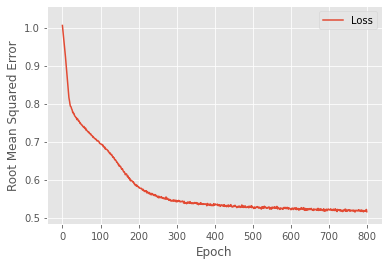

In [197]:

def plot_the_loss_curve(epochs, rmse):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show() 
    
    
#history = model.fit(train_df_norm.batch(batch_size),validation_data = test_df_norm.batch(batch_size),
 #         epochs=epochs, shuffle=True )
epochs = history.epoch

# Isolate the mean absolute error for each epoch.
hist = pd.DataFrame(history.history)
rmse = hist["root_mean_squared_error"]

plot_the_loss_curve(epochs, rmse)

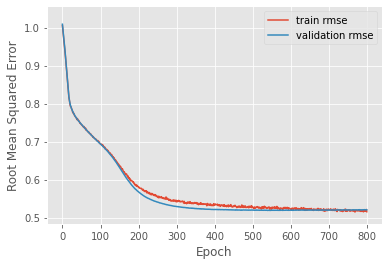

In [198]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Root Mean Squared Error")

plt.plot(epochs, hist.root_mean_squared_error, label ="train rmse")
plt.plot(epochs, hist.val_root_mean_squared_error, label ="validation rmse")
plt.legend()
plt.ylim([hist.root_mean_squared_error.min()*0.94, hist.root_mean_squared_error.max()*1.05])
plt.show()

In [199]:
predictions = model.predict(test_np)

##This gives us the normalized predictions since cnt in train was normalized too
predictions_df_norm = pd.DataFrame(predictions)
#predictions_df_mean = predictions_df_norm.mean()
#predictions_df_std = predictions_df_norm.std()
#predictions_df = (predictions_df_norm * predictions_df_std)+ predictions_df_mean

#predictions_df = (predictions_df_norm * std_cnt)+ mean_cnt
submission = pd.DataFrame (columns = ['Timestamp','cnt'])
#test_timestamp = test_timestamp.to_numpy()
test_timestamp.tolist()
#test_timestamp = pd.Series (test_timestamp)
submission['Timestamp'] = test_timestamp
#submission['cnt'] = predictions_df
#predictions_np = predictions_df.to_numpy()

submission['cnt'] = predictions_df_norm
submission.head()


,Timestamp,cnt
0,2015-01-04 00:00:00,180.135010
1,2015-01-04 01:00:00,121.540283
2,2015-01-04 03:00:00,-4.049316
3,2015-01-04 04:00:00,36.364136
4,2015-01-04 05:00:00,109.825317


In [201]:
predictions_df.mean()  #1152.748535

0    1152.063477
dtype: float32

In [202]:
mean_cnt  #1138.0988300744498

1138.0988300744498

In [203]:
submission.to_csv('submission_Dana.csv',index=False)
